## Joshua Payapulli Final Project ##

Name: Joshua Payapulli ----
USC ID: 3751786221

In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import tensorflow_addons as tfa
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16

/Users/joshuapayapulili/anaconda3/envs/env/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [4]:
import random
import tensorflow as tf
from PIL import Image 

def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        
        img = Image.open(img_loc_str).convert('RGB')
        img = np.array(img)
        
        # Normalize the image
        img = img / 255.0

        # Convert label to integer for binary classification
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    X.set_shape([299, 299, 3])
    y.set_shape([])
    
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

# Training CNN + MLP

## (ci) Empirical Regularization

In [5]:
def augment(image, label):

    if len(image.shape) == 4:  # Check if the image tensor has 4 dimensions
        image = tf.reshape(image, [299, 299, 3])  # Reshape to 3
    
    # Random Zoom
    zoom_scale = tf.random.uniform([], 1, 1.2)
    zoomed_height = tf.cast(299 * zoom_scale, tf.int32)
    zoomed_width = tf.cast(299 * zoom_scale, tf.int32)
    image = tf.image.resize(image, [zoomed_height, zoomed_width])
    image = tf.image.random_crop(image, size=[299, 299, 3])

    # Random Brightness and Contrast
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random Rotation
    angle = tf.random.uniform([], minval=-math.pi/4, maxval=math.pi/4)
    image = tfa.image.rotate(image, angle)

    # Random Translation
    image = tf.image.pad_to_bounding_box(image, 10, 10, 319, 319)  # Pad the image
    image = tf.image.random_crop(image, size=[299, 299, 3])  # Crop to original size

    return image, label

# Apply the augment function to each element in the dataset
tf_dataset_train = tf_dataset_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Batch the training data
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

## (cii) Training the model

In [6]:
# Model configuration
input_shape = (299, 299, 3)  # Assuming RGB images of size 299x299

# Define the model
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Second convolutional block
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Third convolutional block
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten and dense layers
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 299, 299, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 299, 299, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 299, 299, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 149, 149, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 149, 149, 64)      2

In [7]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Training the model
history = model.fit(
    tf_dataset_train,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
928/928 [==============================] - 873s 940ms/step - loss: 2.2079 - accuracy: 0.5869 - val_loss: 0.8844 - val_accuracy: 0.3218
Epoch 2/20


/Users/joshuapayapulili/anaconda3/envs/env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


928/928 [==============================] - 875s 943ms/step - loss: 0.7992 - accuracy: 0.5877 - val_loss: 0.8125 - val_accuracy: 0.3218
Epoch 3/20
928/928 [==============================] - 876s 944ms/step - loss: 0.7547 - accuracy: 0.5878 - val_loss: 0.7677 - val_accuracy: 0.3218
Epoch 4/20
928/928 [==============================] - 877s 945ms/step - loss: 0.7033 - accuracy: 0.5887 - val_loss: 1.5396 - val_accuracy: 0.3218
Epoch 5/20
928/928 [==============================] - 877s 945ms/step - loss: 0.6752 - accuracy: 0.5904 - val_loss: 0.7151 - val_accuracy: 0.3218
Epoch 6/20
928/928 [==============================] - 875s 943ms/step - loss: 0.6564 - accuracy: 0.5875 - val_loss: 3.2974 - val_accuracy: 0.3218
Epoch 7/20
928/928 [==============================] - 872s 940ms/step - loss: 0.6562 - accuracy: 0.5888 - val_loss: 0.6659 - val_accuracy: 0.3218
Epoch 8/20
928/928 [==============================] - 872s 940ms/step - loss: 0.6582 - accuracy: 0.5872 - val_loss: 0.6405 - val_accura

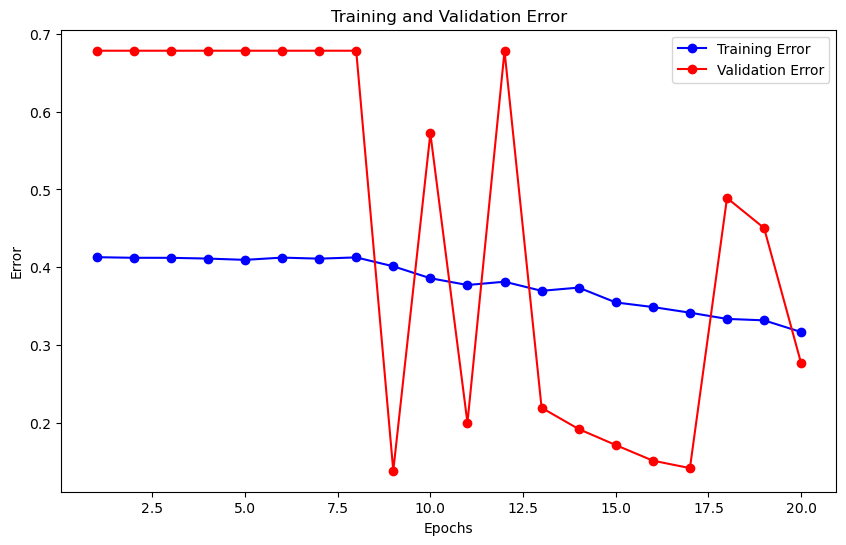

In [8]:
train_error = [1 - acc for acc in history.history['accuracy']]
val_error = [1 - acc for acc in history.history['val_accuracy']]

epochs = range(1, len(train_error) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_error, 'bo-', label='Training Error')
plt.plot(epochs, val_error, 'ro-', label='Validation Error')
plt.title('Training and Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

## (ciii) Precision, Recall, and F1 score

In [9]:
best_model = load_model('best_model.h5')
predictions = best_model.predict(tf_dataset_test)

928/928 [==============================] - 223s 240ms/step


In [11]:
predicted_labels = np.argmax(predictions, axis=1)

# Get labels from test_data
y_labels = []
for images, labels in tf_dataset_test.unbatch():
    y_labels.append(labels.numpy())

y_labels = np.array(y_labels)
predicted_labels_flat = predicted_labels.flatten()
y_labels_flat = y_labels.flatten()

report = classification_report(y_labels_flat, predicted_labels_flat)
print(report)

              precision    recall  f1-score   support

           0       0.41      0.54      0.47     12235
           1       0.59      0.45      0.51     17444

    accuracy                           0.49     29679
   macro avg       0.50      0.50      0.49     29679
weighted avg       0.51      0.49      0.49     29679



# (d) Transfer Learning

## (di) Initialize pre-trained networks

In [12]:
# Initialize base models and freeze the weights/layers
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model_efficientnet.trainable = False

base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model_resnet.trainable = False

base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model_vgg16.trainable = False

## (dii) Empirical regularization

Data has already undergone empirical regularization in part c.

## (diii) Last layer architecture

In [13]:
efficientnet_model = Sequential([
    base_model_efficientnet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

resnet_model = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

vgg16_model = Sequential([
    base_model_vgg16,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

## (div) Training the models

In [15]:
# EfficientNet
print("Training EfficientB0 based model...")
efficientnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for EfficientNet
early_stopping_effnet = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint_effnet = ModelCheckpoint('best_model_effnet.h5', monitor='val_loss', save_best_only=True)

# Training the EfficientNet model
history_effnet = efficientnet_model.fit(
    tf_dataset_train,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping_effnet, model_checkpoint_effnet]
)

# ResNet50
print("Training ResNet50 based model...")
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for ResNet
early_stopping_resnet = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint_resnet = ModelCheckpoint('best_model_resnet.h5', monitor='val_loss', save_best_only=True)

# Training the ResNet50 model
history_resnet = resnet_model.fit(
    tf_dataset_train,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping_resnet, model_checkpoint_resnet]
)

# VGG16
print("Training VGG16 based model...")
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for VGG16
early_stopping_vgg = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint_vgg = ModelCheckpoint('best_model_vgg.h5', monitor='val_loss', save_best_only=True)

# Training the VGG16 model
history_vgg = vgg16_model.fit(
    tf_dataset_train,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping_vgg, model_checkpoint_vgg]
)

Training EfficientB0 based model...
Epoch 1/20
928/928 [==============================] - 584s 627ms/step - loss: 0.7504 - accuracy: 0.5513 - val_loss: 0.7001 - val_accuracy: 0.2989
Epoch 2/20
928/928 [==============================] - 570s 615ms/step - loss: 0.6847 - accuracy: 0.5766 - val_loss: 0.7237 - val_accuracy: 0.3218
Epoch 3/20
928/928 [==============================] - 573s 617ms/step - loss: 0.6790 - accuracy: 0.5853 - val_loss: 0.7290 - val_accuracy: 0.3218
Epoch 4/20
928/928 [==============================] - 573s 617ms/step - loss: 0.6787 - accuracy: 0.5868 - val_loss: 0.7477 - val_accuracy: 0.3218
Epoch 5/20
928/928 [==============================] - 598s 644ms/step - loss: 0.6775 - accuracy: 0.5865 - val_loss: 0.7399 - val_accuracy: 0.3218
Epoch 6/20
928/928 [==============================] - 563s 607ms/step - loss: 0.6776 - accuracy: 0.5852 - val_loss: 0.7492 - val_accuracy: 0.3218
Epoch 6: early stopping
Training ResNet50 based model...
Epoch 1/20
928/928 [===========

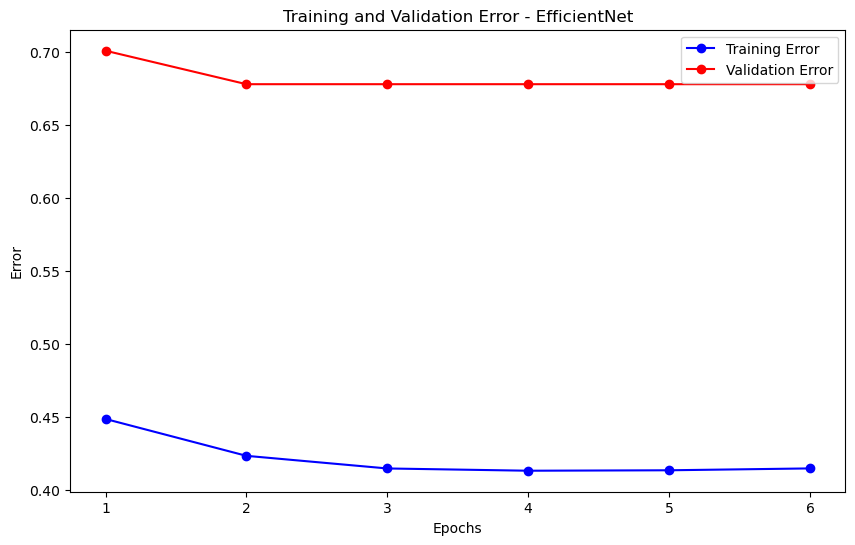

In [16]:
train_error = [1 - acc for acc in history_effnet.history['accuracy']]
val_error = [1 - acc for acc in history_effnet.history['val_accuracy']]

epochs = range(1, len(train_error) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_error, 'bo-', label='Training Error')
plt.plot(epochs, val_error, 'ro-', label='Validation Error')
plt.title('Training and Validation Error - EfficientNet')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

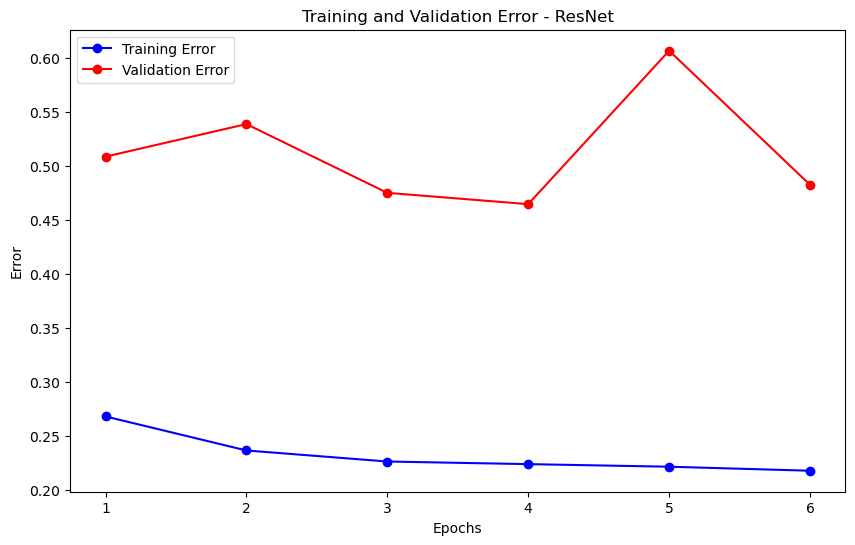

In [17]:
train_error = [1 - acc for acc in history_resnet.history['accuracy']]
val_error = [1 - acc for acc in history_resnet.history['val_accuracy']]

epochs = range(1, len(train_error) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_error, 'bo-', label='Training Error')
plt.plot(epochs, val_error, 'ro-', label='Validation Error')
plt.title('Training and Validation Error - ResNet')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

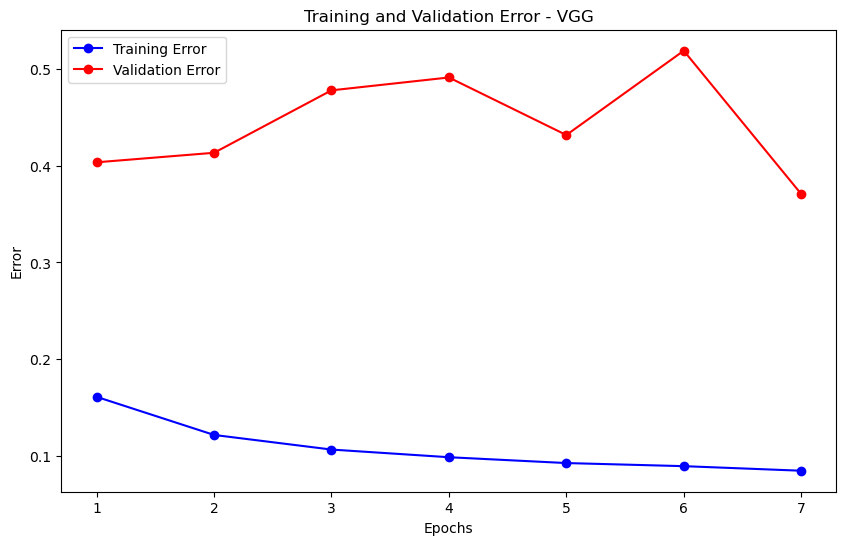

In [18]:
train_error = [1 - acc for acc in history_vgg.history['accuracy']]
val_error = [1 - acc for acc in history_vgg.history['val_accuracy']]

epochs = range(1, len(train_error) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_error, 'bo-', label='Training Error')
plt.plot(epochs, val_error, 'ro-', label='Validation Error')
plt.title('Training and Validation Error - VGG')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

## (dv) Precision, Recall, and F1 score

In [23]:
best_model_eff = load_model('best_model_effnet.h5')
predictions = best_model_eff.predict(tf_dataset_test)

predicted_labels = np.argmax(predictions, axis=1)
predicted_labels_flat = predicted_labels.flatten()

report = classification_report(y_labels_flat, predicted_labels_flat)
print("EfficientNet classification report: \n")
print(report)

928/928 [==============================] - 410s 441ms/step
EfficientNet classification report: 

              precision    recall  f1-score   support

           0       0.42      0.25      0.31     12235
           1       0.59      0.76      0.66     17444

    accuracy                           0.55     29679
   macro avg       0.51      0.50      0.49     29679
weighted avg       0.52      0.55      0.52     29679



In [24]:
best_model_res = load_model('best_model_resnet.h5')
predictions = best_model_res.predict(tf_dataset_test)

predicted_labels = np.argmax(predictions, axis=1)
predicted_labels_flat = predicted_labels.flatten()

report = classification_report(y_labels_flat, predicted_labels_flat)
print("ResNet classification report: \n")
print(report)

928/928 [==============================] - 1102s 1s/step
ResNet classification report: 

              precision    recall  f1-score   support

           0       0.41      0.20      0.27     12235
           1       0.59      0.80      0.68     17444

    accuracy                           0.55     29679
   macro avg       0.50      0.50      0.47     29679
weighted avg       0.51      0.55      0.51     29679



In [25]:
best_model_vgg = load_model('best_model_vgg.h5')
predictions = best_model_vgg.predict(tf_dataset_test)

predicted_labels = np.argmax(predictions, axis=1)
predicted_labels_flat = predicted_labels.flatten()

report = classification_report(y_labels_flat, predicted_labels_flat)
print("VGG classification report: \n")
print(report)

928/928 [==============================] - 3397s 4s/step
VGG classification report: 

              precision    recall  f1-score   support

           0       0.41      0.34      0.37     12235
           1       0.59      0.65      0.62     17444

    accuracy                           0.53     29679
   macro avg       0.50      0.50      0.50     29679
weighted avg       0.51      0.53      0.52     29679



## (dvi) Compare the results

The CNN + MLP model did not really seem to learn from the data as it has a training accuracy 0.57 and a test accuracy of 0.49. The Transfer Learning models (specifically the ResNet and VGG models) however are able to learn from the data but are likely overfitting. ResNet has a training accuracy of 0.78 and VGG has a training accuracy of 0.92, with a test accuracy of 0.55, 0.53 respectively.

As such, we can say that the Transfer learning models (specifically ResNet and VGG) outperform the CNN + MLP model as they are at least able to learn from the data, despite definitely being overfit, they also have a slightly higher test accuracy. This makes sense as our test data (images of Mars) is probably very different to the data that these Transfer Learning models learned on, so these models are probably learning some pattern from these data that does not generalize well to new unseen data of this type (Martian terrain).